In [1]:
import pickle
import pandas as pd
import numpy
import re
import os
import numpy as np
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec
import warnings
import mplcursors
import matplotlib.pyplot as plt
import mplcursors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import PyQt6
import PySide6
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.metrics import silhouette_score

#venv is M2

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1108)>


### K Means of Document Clusters

After learning K-means, we have videos clustered by similarity according to Doc2Vec.

In [2]:
path = '../data_cleaning/data/youtube_dislike_dataset.csv' #raw download
clean_transcripts = pd.read_csv(path)
clean_transcripts.head(3)

,video_id,title,channel_id,channel_title,published_at,view_count,likes,dislikes,comment_count,tags,description,comments
0,--0bCF-iK2E,Jadon Sancho Magical Skills & Goals,UC6UL29enLNe4mqwTfAyeNuw,Bundesliga,2021-07-01 10:00:00,1048888,19515,226,1319,football soccer ftbol alemn Bundesliga season ...,Enjoy the best skills and goals from Jadon San...,"Respect to Dortmund fans,must be sad losing hi..."
1,--14w5SOEUs,Migos - Avalanche (Official Video),UCGIelM2Dj3zza3xyV3pL3WQ,MigosVEVO,2021-06-10 16:00:00,15352638,359277,7479,18729,Migos Avalanche Quality Control Music/Motown R...,"Watch the the official video for Migos - ""Aval...",Migos just makes me want to live my live to th...
2,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,UClBKH8yZRcM4AsRjDVEdjMg,Television Academy,2021-09-20 01:03:32,925281,11212,401,831,,Hannah Waddingham wins the Emmy for Supporting...,Hannah's energy bursts through any screen. Wel...


In [3]:
#splitting the dislikes dataframe by the median 
clean_transcripts['dislikes'].median()
below_median = clean_transcripts[clean_transcripts['dislikes'] < 796]
above_median = clean_transcripts[clean_transcripts['dislikes'] >= 796]
print(len(above_median))
print(len(below_median))

18712
18710


In [4]:
### Distribution of Dislike Counts (Log Base 2)
#clean_transcripts['log_dislikes'] = np.log2(clean_transcripts['dislikes'])
#clean_transcripts['log_dislikes'].hist(bins=100)
#clean_transcripts['log_dislikes'].replace(-np.inf, 0, inplace=True)
#print(clean_transcripts['log_dislikes'].hist())

Create Final Text Column for Machine Learning and Remove Stop Words

In [5]:
below_median["all_text"] = below_median["title"] + below_median["description"]
above_median["all_text"] = above_median["title"] + above_median["description"]

In [6]:
stop = stopwords.words('english')
below_median['all_text'] = below_median['all_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
above_median['all_text'] = above_median['all_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

### Doc2Vec

In [7]:
#Careful Which Column is selected for d2v training

In [8]:
all_content_train_below = below_median['title'].astype(str).tolist()
all_content_train_above = above_median['title'].astype(str).tolist()

In [9]:
def fit_d2v(all_content_train, window=5, vector_size=100, min_count=500, workers=7, dm=0, alpha=0.025, min_alpha=0.001):
    tagged_documents = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(all_content_train)]
    #window – The maximum distance between the current and predicted word within a sentence.
    #vector_size - Dimensionality of the feature vectors.
    #dm ({1,0}, optional) – Defines the training algorithm. If dm=1, ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.
    d2v_model = Doc2Vec(tagged_documents, vector_size=100, window=10, min_count=500, workers=7, dm=1, alpha=0.025, min_alpha=0.001)
    d2v_model.train(tagged_documents, total_examples=d2v_model.corpus_count, epochs=50, start_alpha=0.002, end_alpha=-0.016)
    return d2v_model
d2v_model_below = fit_d2v(all_content_train_below)
d2v_model_above= fit_d2v(all_content_train_above)

#default trains in 6 mins on half of dislikes kaggle dataset on 18k titles when model type=1

### KMeans

In [10]:
from collections import Counter
#https://medium.com/@ermolushka/text-clusterization-using-python-and-doc2vec-8c499668fa61
def fit_kmeans(n_clusters,d2v_model,pc=5,max_iter=10000):
    kmeans_model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=max_iter)
    X = kmeans_model.fit(d2v_model.dv.vectors)
    labels = kmeans_model.labels_.tolist()
    pca = PCA(n_components=pc,random_state=42).fit(d2v_model.dv.vectors)
    datapoint = pca.transform(d2v_model.dv.vectors)
    value_counts = Counter(labels)
    eval_x = d2v_model.dv.vectors
    eval_y_pred = kmeans_model.predict(eval_x)
   # centers = kmeans_model.cluster_centers_ #need to transform with pca and such?
    return n_clusters, datapoint, labels, value_counts,eval_x,eval_y_pred

Finding the Ideal Number of Clusters (Silhouette Score)

In [11]:
def best_model_silhouette(trained_d2v, highest_cluster_val=20):
    scores = []
    max_score = 0
    max_n_cluster = None
    max_datapoint = None
    max_labels = None
    max_value_counts = None
    max_centers = None
    for i in tqdm(range(2,highest_cluster_val)):
        n_clusters_below, datapoint_below, labels_below, value_counts_below,eval_x,eval_y_pred = fit_kmeans(i,trained_d2v)
        #plot_km = plot_kmeans(n_clusters_below, datapoint_below, labels_below)
        score = silhouette_score(eval_x,eval_y_pred)
        scores.append(score)
        if score > max_score:
            max_score = score
            max_n_cluster = n_clusters_below
            max_datapoint = datapoint_below
            max_labels = labels_below
            max_value_counts =value_counts_below
           # max_centers = kmeans.cluster_centers_
    print(scores)
    print(f"max silhouette score (cluster quality): {max_score}")
    return max_n_cluster, max_datapoint, max_labels,max_value_counts

In [28]:
%matplotlib qt

def plot_kmeans(n_clusters, datapoint,labels):
    try:
        label1 = [
        "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#00FFFF", "#FF00FF",  # Primary colors and cyan, magenta, and yellow
        "#800000", "#008000", "#000080", "#808000", "#008080", "#800080",  # Darker shades of the primary colors and their combinations
        "#FFA500", "#FFFF99", "#FF99CC", "#CC99FF", "#99CCFF", "#99FFCC",  # Orange, light yellow, light pink, light purple, light blue-green combinations
        "#FFC0CB", "#800080", "#008080", "#00FF00", "#FF0000", "#0000FF",  # Pink, purple, teal, lime, red, blue
        "#000000", "#808080", "#C0C0C0", "#FFFFFF", "#F5F5DC", "#A52A2A",  # Black, gray shades, white, beige, brown
        "#F0FFFF", "#F0F8FF", "#FAEBD7", "#7FFFD4", "#F5F5F5", "#FFD700",  # Azure, alice blue, antique white, aquamarine, white smoke, gold
        "#D2B48C", "#ADFF2F", "#FF69B4", "#4B0082", "#7FFF00", "#800000"]  # Tan, green-yellow, hot pink, indigo, chartreuse, maroon]    label1 = labels1[:n_clusters]
        color = [label1[i] for i in labels]
        x,y = datapoint[:, 0], datapoint[:, 1]
        fig, ax = plt.subplots()
        scatter = ax.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
        plt.title(f"KMeans Clustering of: {n_clusters} Clusters")
        plt.show()
    except AttributeError:
        pass

In [33]:
def plot_kmeans_density(n_clusters, datapoint,labels):
    try:
        label1 = [
        "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#00FFFF", "#FF00FF",  # Primary colors and cyan, magenta, and yellow
        "#800000", "#008000", "#000080", "#808000", "#008080", "#800080",  # Darker shades of the primary colors and their combinations
        "#FFA500", "#FFFF99", "#FF99CC", "#CC99FF", "#99CCFF", "#99FFCC",  # Orange, light yellow, light pink, light purple, light blue-green combinations
        "#FFC0CB", "#800080", "#008080", "#00FF00", "#FF0000", "#0000FF",  # Pink, purple, teal, lime, red, blue
        "#000000", "#808080", "#C0C0C0", "#FFFFFF", "#F5F5DC", "#A52A2A",  # Black, gray shades, white, beige, brown
        "#F0FFFF", "#F0F8FF", "#FAEBD7", "#7FFFD4", "#F5F5F5", "#FFD700",  # Azure, alice blue, antique white, aquamarine, white smoke, gold
        "#D2B48C", "#ADFF2F", "#FF69B4", "#4B0082", "#7FFF00", "#800000"]  # Tan, green-yellow, hot pink, indigo, chartreuse, maroon]    label1 = labels1[:n_clusters]
        color = [label1[i] for i in labels]
        x,y = datapoint[:, 0], datapoint[:, 1]
        plt.hist2d(x, y, (5, 5), cmap=plt.cm.jet)
        plt.colorbar()
        #https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density
    except AttributeError:
        pass

*Interpretation of Plots:*

Even if the clusters aren't well defined, each individual point is placed

in space next to the similar similar documents based on the language in their
  
titles. So if a user queried a specific point or a new point with a text query, 

the closest related videos could be retrieved (after some transformations)

In [38]:
%matplotlib inline
max_n_cluster, max_datapoint, max_labels,max_value_counts = best_model_silhouette(d2v_model_below, highest_cluster_val=3)
below_save = [max_n_cluster, max_datapoint, max_labels,max_value_counts]
#0.18447506427764893 with cluster 3

100%|██████████| 1/1 [00:12<00:00, 12.28s/it]

[0.18719737]
max silhouette score (cluster quality): 0.18719737231731415


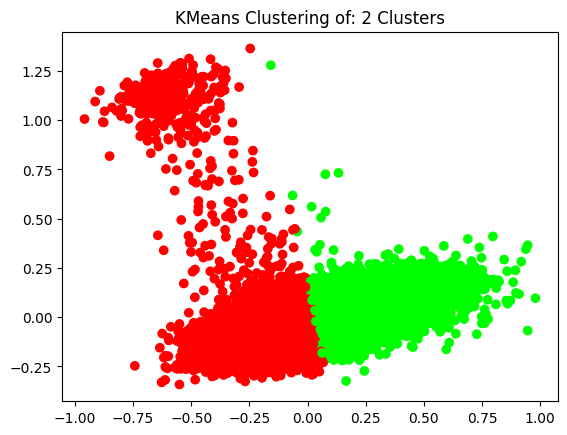

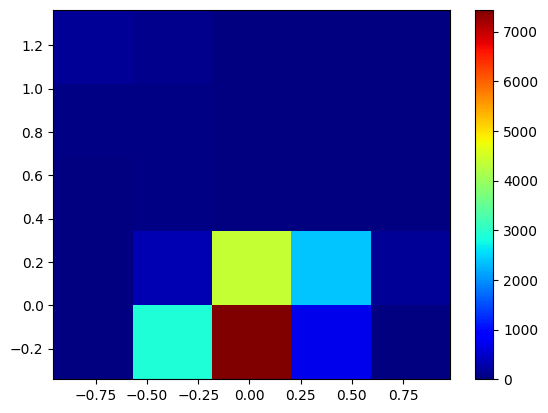

In [39]:
%matplotlib inline
plot_kmeans(max_n_cluster, max_datapoint, max_labels)
plot_kmeans_density(max_n_cluster, max_datapoint, max_labels)

In [40]:
max_n_cluster, max_datapoint, max_labels,max_value_counts = best_model_silhouette(d2v_model_above, highest_cluster_val=5)
above_save = [max_n_cluster, max_datapoint, max_labels,max_value_counts]

100%|██████████| 3/3 [00:34<00:00, 11.34s/it]

[0.18444252, 0.11354564, 0.12267877]
max silhouette score (cluster quality): 0.18444252014160156


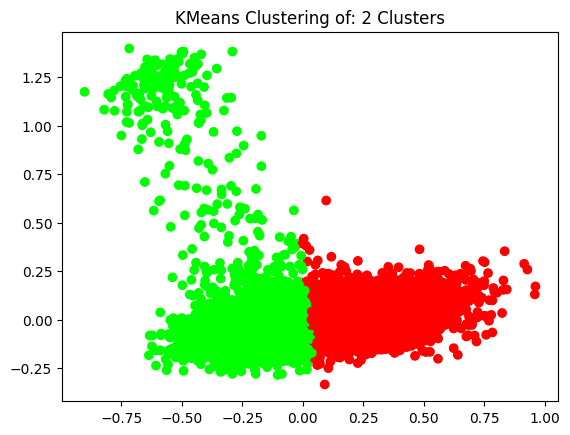

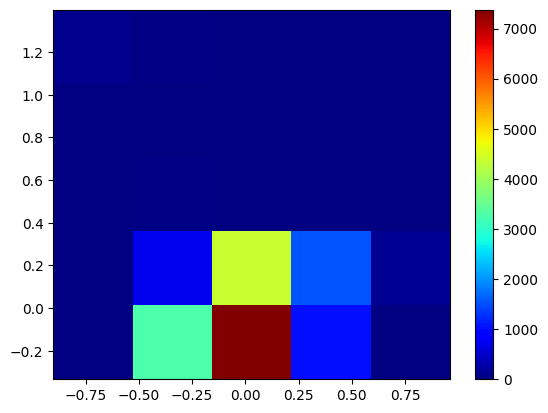

In [41]:
%matplotlib inline
plot_kmeans(max_n_cluster, max_datapoint, max_labels)
plot_kmeans_density(max_n_cluster, max_datapoint, max_labels)

This dictionary shows the count videos in each kmeans cluster

In [42]:
#above_save = [max_n_cluster, max_datapoint, max_labels,max_value_counts]
print(f"Above Median Dislikes cluster {above_save[-1]}")
print(f"Below Median Dislikes cluster {below_save[-1]}")

Above Median Dislikes cluster Counter({1: 10858, 0: 7854})
Below Median Dislikes cluster Counter({0: 10829, 1: 7881})


In [43]:
#We can find the Clusters with the Least Points which may be more informative
#sorted_keys_below = sorted(below_save[-1], key=lambda k: below_save[-1][k])
#sorted_keys_above = sorted(above_save[-1], key=lambda k: above_save[-1][k])
#print(f"The Cluster Numbers from Least to Most Points {sorted_keys})")

Careful Which Dataframe is Selected

In [44]:
def print_group_examples(group_num, total_examples,sorted_keys,labels, dataframe):
    found = 0
    results = []
    for count in range(len(dataframe)):
        if labels[count]==group_num:
            found+=1
            results.append(dataframe['title'].iloc[count])
        if found ==total_examples:
            break
    
    return(results)

In [46]:
print("Below Median Dislikes")
print(print_group_examples(sorted_keys_below[0],5,sorted_keys_below,below_save[-2],below_median))
print("")
print(print_group_examples(sorted_keys_below[1],5,sorted_keys_below,below_save[-2],below_median))
print("")
print(print_group_examples(sorted_keys_below[2],5,sorted_keys_below,below_save[-2],below_median))

Below Median Dislikes
['Supporting Actress in a Comedy: 73rd Emmys', "JO1'YOUNG (JO1 ver.)' PERFORMANCE VIDEO", 'The Breakfast Club Reacts to Kanye West\'s "DONDA" Listening Party', 'Colby Covington and Tyron Woodley finally face off | UFC Vegas 11', '3...CS']

['Jadon Sancho  Magical Skills & Goals', 'Why Retaining Walls Collapse', 'TEST COMPLET du Google Pixel 6 Pro : Une EXPRIENCE  part et GNIALE !', 'We sold my bike for charity! Find out who got it and more', 'How To Get *EVERY STAND* In AUT (A Universal Time) | A Universal Time Stand Guide ROBLOX']



IndexError: list index out of range

In [47]:
print("Above Median Dislikes")
print(print_group_examples(sorted_keys_above[0],5,sorted_keys_above,above_save[-2],above_median))
print(print_group_examples(sorted_keys_above[1],5,sorted_keys_above,above_save[-2],above_median))
print(print_group_examples(sorted_keys_above[2],5,sorted_keys_above,above_save[-2],above_median))

Above Median Dislikes
["IVE  'ELEVEN' MV", 'Trump to go ahead with next TV debate but Biden refuses if he still has Covid-19', 'is that a shark ??? #shorts #datrie', 'JE ME SUIS FILM EN TRAIN DE DORMIR EN COUPLE', " (BamBam) 'riBBon' MV"]
['Migos - Avalanche (Official Video)', 'Lucifer Season 5 Part 2 | Official Trailer | Netflix', 'BTS ()  Butter & Dynamite | SiriusXM', 'I Failed Card Swipe 30+ Times LIVE In Front Of 200k People And All My Friends', 'Selena: The Series | Official Trailer | Netflix']


IndexError: list index out of range